In [1]:
from config import *
from dataset import bandpass_filter, cascaded_filters
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib
%matplotlib notebook

In [2]:
df = pd.read_csv('../ECG_Data/WA20_pre1001.txt', header=None, usecols=[1, 3])

In [3]:
def pad_to_match(array, width):
    return (np.append(array, np.zeros(width - len(array) % width))
                .reshape(-1, width))

def absmaxND(a, axis=None):
    amax = a.max(axis)
    amin = a.min(axis)
    return (np.where(-amin > amax, amin, amax))


def standardize(array, width=5000):
    array_len = len(array)
    array_ = pad_to_match(array, width)
    sign = absmaxND(array_, axis=1)
    std = np.std(array_, axis=1)
    array /= np.repeat(sign, width)[:array_len]
    return array

In [4]:
ecg = np.array(df[1][0:307200])
signal = np.array(df[3][0:307200])
clean_ecg = cascaded_filters(ecg, 1, 400, 10, nyq)
standardized_clean_ecg = standardize(clean_ecg)
print(signal)

[0. 0. 0. ... 0. 0. 0.]


<IPython.core.display.Javascript object>


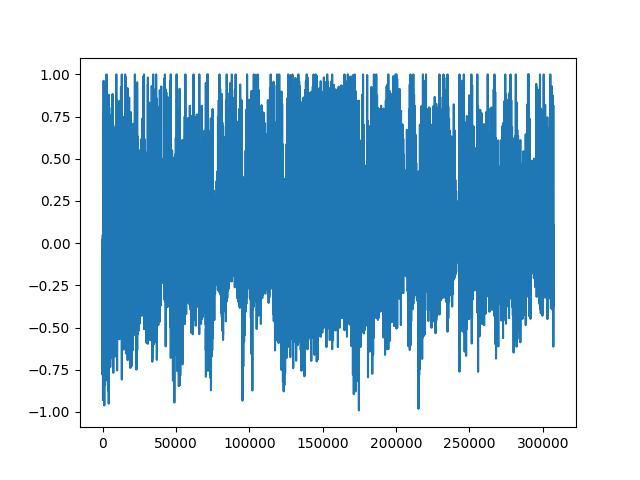

In [5]:
plt.plot(standardized_clean_ecg)
plt.show()

<IPython.core.display.Javascript object>


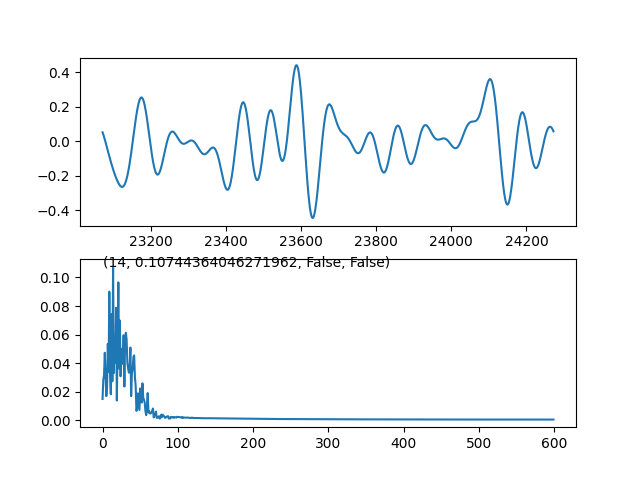

interactive(children=(IntSlider(value=50, description='high_cutoff'), IntSlider(value=0, description='low_cuto…

<function __main__.update(high_cutoff=50, low_cutoff=0, ind=0, width=800)>

In [17]:
import scipy.integrate as integrate
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
from scipy.fft import fft, ifft

def fft_filter(ecg,  ind0=0, ind1=600, cutoff_high=200, cutoff_low=0):
    fft_signal = fft(ecg[ind0:ind1])
    
    # Identify noise frequencies and mask them out
    # For example, setting frequencies with too high amplitude to zero
    n_samples = ind1 - ind0
    amplitudes = 2 / n_samples * np.abs(fft_signal) 
    frequencies = np.fft.fftfreq(n_samples) * n_samples

#     fft_signal = np.where(np.abs(frequencies) < cutoff_high, fft_signal, 0)
    
    # Inverse Fourier Transform to get the cleaned signal
    ecg = ifft(fft_signal)
    return ecg, amplitudes, frequencies

fft_ecg, amp, freq = fft_filter(standardized_clean_ecg, 0, 600)

line1, = ax1.plot(fft_ecg[0:600])
line2, = ax2.plot(freq[:len(freq) // 2], amp[:len(freq) // 2])

# line, = ax.plot(fft_ecg)

def update(high_cutoff=50, low_cutoff=0, ind=0, width=800):
    fft_ecg, amp, freq = fft_filter(standardized_clean_ecg, ind, ind+width, high_cutoff, low_cutoff)
    
    line1.set_xdata(np.linspace(ind, ind+width, width))
    line1.set_ydata(fft_ecg)
    ax1.relim()
    ax1.autoscale()
    amp = amp[:len(freq) // 2]
    line2.set_xdata(freq[:len(freq) // 2])
    line2.set_ydata(amp)
    if len(ax2.texts) > 0:
        del ax2.texts[-len(ax2.texts):]
    argmax, max_ = np.argmax(amp[10:]) + 10, np.max(amp[10:])
    ax2.text(0, np.max(amp), (argmax, max_, argmax > 13 and max_ > 0.6, integrate.simps(amp[10:100]) > 500))
    ax2.relim()
    ax2.autoscale()
    fig.canvas.draw_idle()

interact(update, high_cutoff = (0, 100, 1), low_cutoff=(0, 100, 1), ind=(0, 26000, 1), width=(0, 1200, 1))

In [87]:
from sklearn.cluster import k_means
from sklearn import decomposition, cluster
amplitudes = []
ecgs = []
for ind in range(0, len(ecg-600), 600):
    ecg_temp = ecg[ind:ind+600]
    _, amp, freq = fft_filter(ecg, ind, ind+600)
    amp = amp[:len(freq) // 2]
#     amp /= np.std(amp)
    amplitudes.append(amp)
    ecgs.append(ecg_temp)

amp_k_means = cluster.KMeans(n_clusters=4, random_state=0).fit(amplitudes)
ecg_k_means = cluster.KMeans(n_clusters=4, random_state=0).fit(ecgs)

<IPython.core.display.Javascript object>


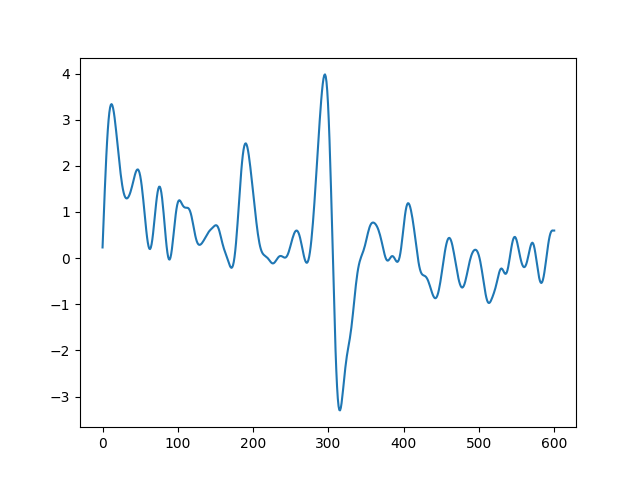

interactive(children=(IntSlider(value=0, description='ind', max=26000), Output()), _dom_classes=('widget-inter…

<function __main__.update(ind=0)>

In [75]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

fft_ecg, amp, freq = fft_filter(clean_ecg, 0, 600)
line, = ax.plot(fft_ecg)

def update(ind=0):
    width = 600
    fft_ecg, amp, freq = fft_filter(clean_ecg, ind, ind+width)
    amp = amp[:len(freq) // 2].reshape(1, -1)
    
    line.set_xdata(np.linspace(ind, ind+width, width))
    line.set_ydata(clean_ecg[ind:ind+width])
    if len(ax.texts) > 0:
        del ax.texts[-len(ax.texts):]
#     ax.text(ind, 0, amp_k_means.predict(amp[:]))
    ax.text(ind, 0, ecg_k_means.predict(clean_ecg[ind:ind+600].reshape(1, -1)))
    ax.relim()
    ax.autoscale()
    fig.canvas.draw_idle()

interact(update, ind=(0, 26000, 1))

In [ ]:
# pca = decomposition.PCA(n_components=3)
# pca.fit(amplitudes)
# test = pca.transform(amplitudes)

<IPython.core.display.Javascript object>


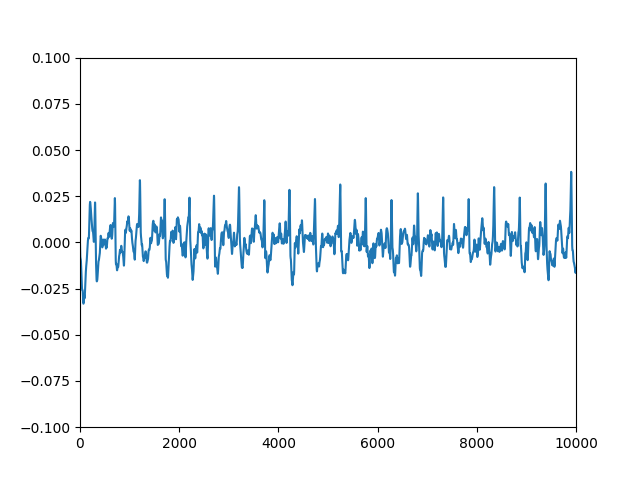

interactive(children=(IntSlider(value=1, description='order_new', max=10), IntSlider(value=20, description='lo…

In [80]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(bandpass_filter(ecg, order, low_cutoff, high_cutoff, nyq))
ax.axis([0, 10000, -0.1, 0.1])

def update(order_new=order, low=20, high=40, n=nyq):
    line.set_ydata(bandpass_filter(ecg, order_new, low, high, n))
    fig.canvas.draw_idle()

interact(update, order_new = (0, 10, 1), low=(0, 400, 1), high=(0, 400, 1));

<IPython.core.display.Javascript object>


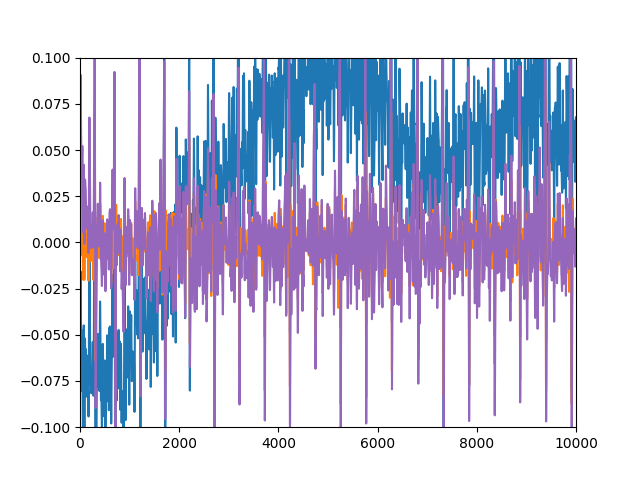

interactive(children=(IntSlider(value=1, description='order_new', max=10), IntSlider(value=20, description='lo…

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(ecg)
filtered = cascaded_filters(ecg, order, 10, 0, nyq)
line, = ax.plot(filtered)

def calc_snr(filtered, ecg, percentile, k):
    filtered_reshaped = (np.append(filtered, np.zeros(interval_length - ecg.size % interval_length))
                .reshape(-1, interval_length))
    ecg_reshaped = (np.append(ecg, np.zeros(interval_length - ecg.size % interval_length))
                         .reshape(-1, interval_length))
    
    diff = np.abs(filtered_reshaped - ecg_reshaped)
    diff /= np.repeat(np.max(diff, axis=1), interval_length).reshape(-1, interval_length)
    diff = np.take_along_axis(diff, np.argpartition(diff, axis=1, kth=k), axis=1)[:, :-k]
    snr = np.sum(diff, axis=1) / (window_size - k)
    
    snr = np.abs(snr)
    snr = np.repeat(snr, interval_length)[:len(ecg)]
    mask = snr < np.percentile(snr, percentile)
    
    return snr, mask

snr, mask = calc_snr(filtered, ecg, 97, 25)

line1, = ax.plot(snr)
line2, = ax.plot(mask)

ax.axis([0, 10000, -0.1, 0.1])

def update(order_new=order, low=20, high=0, n=nyq, percentile=97, k=25):
    filtered = cascaded_filters(ecg, order_new, low, high, nyq)

    snr, mask = calc_snr(filtered, ecg, percentile, k)
    line.set_ydata(filtered)
    line1.set_ydata(snr)
    line2.set_ydata(mask)
    fig.canvas.draw_idle()

interact(update, order_new = (0, 10, 1), low=(0, 400, 1), high=(0, 400, 1), percentile=(0, 100,1), k=(10, 100, 1));

In [ ]:
from scipy.signal import peak_prominences
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.plot(ecg)
peaks, = np.nonzero(signal)
def calc_normalized_prominence(ecg, peaks, percentile):
    filtered = cascaded_filters(ecg, order, 400, 20, nyq)
    filtered_reshaped = (np.append(filtered, np.zeros(interval_length - ecg.size % interval_length))
                    .reshape(-1, interval_length))
    filtered_reshaped /= np.repeat(np.std(filtered_reshaped, axis=1), interval_length).reshape(-1, interval_length)
    filtered = (filtered_reshaped).flatten()[:len(ecg)]
    prominences = peak_prominences(filtered, peaks)
    print(prominences[0])
    
    return filtered, 1, 1

filtered, _, _ = calc_normalized_prominence(ecg, peaks, 97)

    
line, = ax.plot(filtered)
ax.plot(signal)


# snr, mask = calc_snr(filtered, ecg, 97, 25)

# line1, = ax.plot(snr)
# line2, = ax.plot(mask)

# ax.axis([0, 10000, -0.1, 0.1])

# def update(order_new=order, low=20, high=0, n=nyq, percentile=97, k=25):
#     filtered = cascaded_filters(ecg, order_new, low, high, nyq)

#     snr, mask = calc_snr(filtered, ecg, percentile, k)
#     line.set_ydata(filtered)
#     line1.set_ydata(snr)
#     line2.set_ydata(mask)
#     fig.canvas.draw_idle()

# interact(update, order_new = (0, 10, 1), low=(0, 400, 1), high=(0, 400, 1), percentile=(0, 100,1), k=(10, 100, 1));

<IPython.core.display.Javascript object>


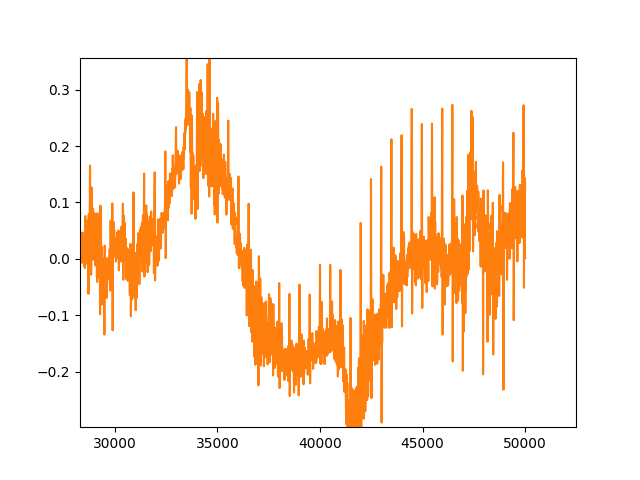

interactive(children=(IntSlider(value=100, description='kernel_size', max=200, min=1, step=3), Output()), _dom…

<function __main__.update(kernel_size)>

In [13]:
from scipy.signal import medfilt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

medfilter_ecg = medfilt(ecg, kernel_size=3)
line, = ax.plot(medfilter_ecg)
ax.plot(ecg)

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def update(kernel_size):
    line.set_ydata(medfilt(ecg, round_up_to_odd(kernel_size)))
    fig.canvas.draw_idle()
    
interact(update, kernel_size=(1, 200, 3))

<IPython.core.display.Javascript object>


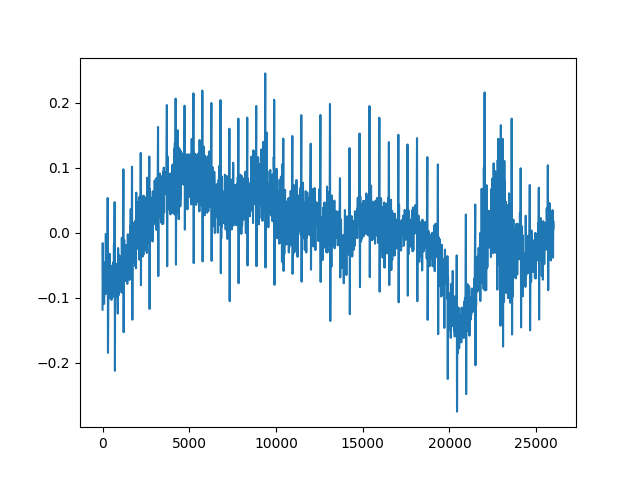

interactive(children=(IntSlider(value=1, description='n', max=10, min=1), Output()), _dom_classes=('widget-int…

<function __main__.update(n=1)>

<IPython.core.display.Javascript object>


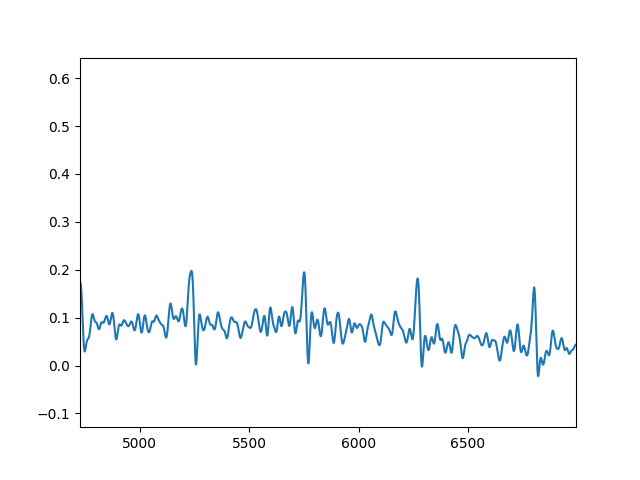

interactive(children=(FloatSlider(value=2.5000000000000004, description='sigma', max=5.0, min=0.1), Output()),…

<function __main__.update(sigma)>